# 法則・曲線・増加率

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [57]:
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import py4macro
import statsmodels.formula.api as sm
from see import see

## はじめに

前章では経済のデータを人の「言動」に例えて説明したが，その比喩をもう少し考えてみよう。「言動」にはパターンがあり，その人の心を映し出しているとも考えられる。例えば，心の優しい人は電車やバスで重い荷物を持つ老人や小さな子を持つ女性に席を譲る回数が多いかも知れない。「あの子が好きだ！」とは決して口に出さない男の子でも，その思いを示唆するような発言や行動があるかも知れない。同じように，経済の「真のメカニズム」の反映としてデータには何らかのパターンが現れる。そのパターンを見つけることに経済学者は時間を割いてきたし，見出したパターンの中には経済を理解する上で非常に重要なヒント隠されている場合がある。ここでは代表的な次のデータのパターンを考える。
* オークンの法則
* フィリップス曲線
* マネー・ストックの増加率とインフレーションの関係

マクロ経済学を勉強した人にとっては必ずと言っていいほど，知名度が高いデータのパターンではないだろうか。これらから「真のメカニズム」の動きが垣間見える事になる。

一方で「真のメカニズム」は不変ではないかも知れない。経済は人が営む活動であり，人が変われば「真のメカニズム」も影響を受けると考えられる。技術進歩（例えば，ビットコイン）や価値観の変化（例えば，「昭和の価値観」から「平成・令和の価値観」への移り変わり），政府・日銀の政策やコロナ禍などの大きなショックは人の行動の変化に影響すると考えるのが自然である。例えば，2020年代の「真のメカニズム」は1970年代のそれとは異なる可能性を拭えない。データを見る際は，そのような変化がないかを注意深く見ることも重要になるだろう。

## オークンの法則

### 説明

この節で使用する記号：
* $Y_t$：GDP
* $\bar{Y}_t$：産出量の自然率水準（もしくは長期的GDP、潜在的GDP）
* $u_t$：失業率
* $\bar{u}_t$：自然失業率（もしくは長期的失業率）

オークンの法則は経験則として次の関係を表す。

$$
\frac{Y_t-\bar{Y}_t}{\bar{Y}_t}=-b\left( u_t-\bar{u}_t\right),\quad b>0
$$ (eq:11-okun)

左辺はGDPの自然率水準からの乖離率（自然率水準を何％上回るかを示す）であり，右辺は失業率の自然率からの乖離（自然失業率を何％ポイント上回るかを示す）である。即ち，GDPと失業率の長期的な値からの乖離には負の関係が存在することを意味している。労働者が生産投入といこと考えると，直感的にも受け入れ易い関係ではないだろうか。では失業率の乖離が1%ポイント上昇するとGDPの乖離率は何%減少するのだろうか。この問いについては，データを使いパラメータ`b`を推定する必要がる。難しい点は、$\bar{Y}_t$と$\bar{u}_t$が観測されないため推定する必要があることである。この点を回避するために、オークンの法則を変数の変化で表す場合もあるが、ここでは上の式を考える。$\bar{Y}_t$と$\bar{u}_t$の推定には様々な洗練された手法があるが、ここでは簡便的にHodrick–Prescottフィルターを使って計算したトレンドを$\bar{Y}$と$\bar{u}$とし，トレンドからの乖離を上の式の左辺と右辺に使う。

以前使ったデータを使うが，次の節でインフレ率について扱うので３つの変数`gdp`，`unemployment_rate`，`inflation`を読み込むことにする。

In [58]:
df = py4macro.data('jpn-q').loc[:,['gdp','unemployment_rate','inflation']]

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1980-03-31 to 2021-12-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                168 non-null    float64
 1   unemployment_rate  168 non-null    float64
 2   inflation          168 non-null    float64
dtypes: float64(3)
memory usage: 5.2 KB


### 失業率の特徴

(sec:11-unemployment)=
### 失業率の特徴

ここでは失業率の特徴を考える。まず図示してみよう。

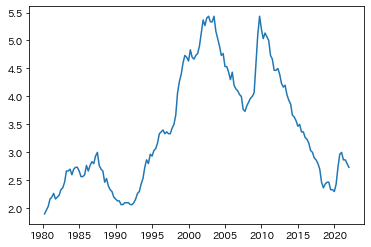

In [60]:
fig, ax = plt.subplots()
ax.plot('unemployment_rate', data=df)
pass

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
df[['unemployment_rate']].plot()
```
````

最初に気づく点は，[前章](chap:10-gdp)で説明した持続性（変化が正（もしくは負）であれば正（もしくは負）の期間が続く傾向にある特徴）が高いとことである。実際，メソッド`.autocorr()`を使い自己相関係数を計算すると非常に高い値が返される。

In [61]:
df['unemployment_rate'].autocorr()

0.9919258402544134

次に，GDPのトレンドからの乖離（％）と失業率のトレンドからの乖離（％ポイント）を比べてみる。まず失業に関する変数を作成するが，対数を取らずに差分をトレンドからの乖離とする。

In [62]:
df['u_rate_trend'] = py4macro.trend(df['unemployment_rate'])
df['u_rate_cycle'] = df['unemployment_rate'] - df['u_rate_trend']

ここで作成した変数は次の変数を表している。
* `unemployment_rate_cycle`：$u_t-\bar{u}_t$

次にGDPのトレンドからの乖離率を計算しよう。
* `gdp_cycle`：$\dfrac{Y_t-\bar{Y}_t}{\bar{Y}_t}=\dfrac{Y_t}{\bar{Y}_t}-1$

In [63]:
df['gdp_cycle'] = 100*( np.log(df['gdp']) -
                        py4macro.trend( np.log(df['gdp']) )
                      )

GDPの乖離と重ねて動きを確認してみる。

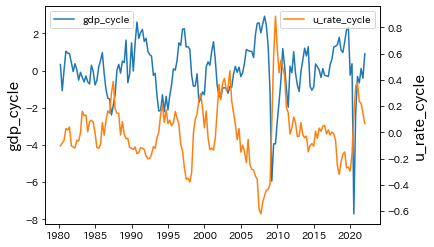

In [64]:
fig, ax1 = plt.subplots()       #1
ax2 = ax1.twinx()               #2
cmap = plt.get_cmap("tab10")    #3
for i, ax, v in zip(            #4
                    [0,1],      #5
                    [ax1, ax2], #6
                    ['gdp_cycle', 'u_rate_cycle'] #7
                   ):
    ax.plot(v, data=df, color=cmap(i)) #8
    ax.legend()                        #9
    ax.set_ylabel(v, size=15)          #10
pass

```{admonition} コードの説明
:class: dropdown

* `#1`：「キャンバス」は`fig`に，「軸」は`ax1`に割り当てる。
* `#2`：`ax1`のメソッド`.tiwinx()`は２軸プロットをするためのものであり，`ax1`は左の縦軸を,`ax2`は右の縦軸を意味する。
* `#3`：`matplotlib`には色の順番が決まったパターンが用意されており，それをカラーマップと呼ぶ。`plt.get_cmap`関数は，その中から`tab10`と呼ばれるものを取り出して`cmap`に割り当てている。[参照リンク](https://matplotlib.org/stable/tutorials/colors/colormaps.html#qualitative)
* `#4`：`zip`関数は`#5`，`#6`，`#7`のそれぞれの要素を順番にタプルとして並べる。
* `#5`：`#3`で指定した`tab10`の`0`番目の色と`1`番目色を指定するために使う整数型のリスト
* `#6`：`#2`で作成した「軸」のリスト
* `#7`：プロットする`df`の列ラベルのリスト
* `#8`：引数`color`は`#3`で割り当てたカラーマップ`tab10`から色を番号で指定する。
* `#9`：凡例を追加する。
* `#10`：縦軸のラベルを指定する。
```

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown

```
ax = df.loc[:,['u_rate_cycle','gdp_cycle']].plot(secondary_y='u_rate_cycle')
ax.set_ylabel('gdp_cycle')
ax.right_ax.set_ylabel('u_rate_cycle')
```
* 最後の行：`ax`のメソッド`.right_ax`を使い右の縦軸にアクセスしている。
````

概ね逆方向に上下していることがわかる。またバブル景気の崩壊後やリーマン・ショック後に，２変数は逆方向に大きく動いていることも確認できる。相関度を確かめるために，`df`のメソッド`corr()`を使い相関係数を計算しよう。

In [65]:
df.loc[:,['u_rate_cycle','gdp_cycle']].corr()

,u_rate_cycle,gdp_cycle
u_rate_cycle,1.000000,-0.627466
gdp_cycle,-0.627466,1.000000


右上と左下の値が２変数の相関係数であり，値は約`-0.64`は強い逆相関を意味する。

また上の図から持続性が高いことが伺える。自己相関係数を計算してみよう。

In [66]:
df['gdp_cycle'].autocorr()

0.6808888095500831

In [67]:
df['u_rate_cycle'].autocorr()

0.8760250306482462

両変数ともトレンドからの乖離は持続性が非常に高いと言える。

### 回帰分析

では実際に式[](eq:11-okun)のスロープ変数$b$を推定してみよう。


In [68]:
formula = 'gdp_cycle ~ u_rate_cycle'   # 1
model = sm.ols(formula, data=df)       # 2
result = model.fit()                   # 3

```{admonition} コードの説明
:class: dropdown

1. 回帰式を文字列で作成し変数`formula`に割り当てる。
2. `sm`の関数`.ols`を使い最小二乗法の準備をし，変数`model`に割り当てる。
    * 引数は(1)の`formula`と`data`に使用する`DataFrame`（ここでは`df_okun`）を指定する。
3. `model`のメソッド`.fit()`を使い自動計算し，その結果を`result`に割り当てる。
```

`result`のメソッド`.summary()`を使い結果を表として表示しよう。

In [69]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_cycle   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     107.8
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           8.95e-20
Time:                        20:17:05   Log-Likelihood:                -261.32
No. Observations:                 168   AIC:                             526.6
Df Residuals:                     166   BIC:                             532.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.919e-11      0.089   3.28e-10   

表の中段から次のことがわかる。
* 定数項の推定値は非常に小さい。即ち、失業率の乖離がゼロある場合、GDPの乖離率もぜろになることを示しており、定数項がない式[](eq:11-okun)と整合的であることわかる。
* パラメータ`b`の推定値は負の値となっていおり、失業率が自然失業率を上回るとGDP乖離率は減少することが確認できる。

＜コメント＞
* Durbin-Watson比は誤差項に正の自己相関が疑われことを示しており，$t$検定の解釈には注意が必要となるが，この点ついての議論は割愛する。

回帰分析の結果を踏まえると，失業率の乖離が`x`％ポイントの場合にGDPのトレンドからの乖離率（％）を計算する関数は次のようになる。

In [70]:
def growth_deviation(x):
    g = result.params[0]+result.params[1]*x
    print(f'失業率の乖離が{x:.1f}％ポイントの場合のGDPのトレンドからの乖離率は約{g:.2f}です。')

`x`が１％ポイントの場合を考えよう。

In [71]:
growth_deviation(1)

失業率の乖離が1.0％ポイントの場合のGDPのトレンドからの乖離率は約-4.01です。


この値を解釈してみよう。失業率が1％ポイント乖離するとしよう。GDPの乖離率は約`-4.1`％になることを示しているが、この値は非常に大きい。例えば、上のプロットで示したGDPのトレンドからの乖離率を考えてみよう。バブル崩壊時の乖離率は約`2.6`％，リーマン・ショック時では約`6`％，コロナ禍では`7.7`％である。これは日本の雇用制度を反映していると考えられる。またトレンドを計算する際に使ったHodrick–Prescottフィルターの影響もあるだろう。

次に、標本の散布図に回帰直線を重ねて表示してみる。まず`result`の属性`.fittedvalues`を使い非説明変数の予測値を抽出することができるので、`df`に`fitted`のラベルを使って新たな列として追加する。

In [72]:
df['fitted_okun'] = result.fittedvalues

図を重ねて表示する。

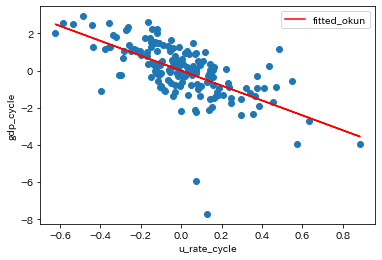

In [73]:
fig, ax = plt.subplots()
ax.scatter(x='u_rate_cycle', y='gdp_cycle',
           data=df, label='')
ax.plot('u_rate_cycle', 'fitted_okun',
        data=df, color='red')
ax.legend()
ax.set(xlabel='u_rate_cycle', ylabel='gdp_cycle')
pass

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
ax = df.plot(x='u_rate_cycle',
              y='gdp_cycle',
              kind='scatter')
df.plot(x='u_rate_cycle',
        y='fitted_okun',
        kind='line',
        color='red',
        ax=ax)
```
````

````{note}
係数の推定値は、`result`の属性`params`でアクセスできることを説明したが、この値を使い次のコードで`gdp_cycle`の予測値を計算することも可能である。
```
ahat = result.params[0]
bhat = result.params[1]
df['fitted'] = ahat + bhat * df['u_rate_cycle']
```
````

プロットの下中央にある２点がリーマン・ショックとコロナ禍によるGDPの乖離率である。この２点に関連して次のことが言える。GDPの乖離率の観点から考えると，２つのショックは「外れ値」的な存在であり，大きなショックだったことがうかがえる。一方，2つのショックに伴う失業率の乖離は大きくなく，`0`に近い値となっている。これはGDPに対するショックが，失業率に影響を及ぼすには時間的なラグが発生することの反映であろう。その結果，回帰直線の傾きに対する影響は限定的だと言える（例えば，失業率の乖離が`0.8`近傍であれば，傾きは絶対値でより大きな値となっていただろう）。従って，傾きが約`-4.1`という結果は，数少ない大きなショックによって大きく影響を受けたものではないとして理解して良いだろう。

## フィリップス曲線

### 説明

マクロ経済学を学んだ人にとって最も馴染み深い関係の一つがフィリップス曲線（PC曲線）ではないだろうか。失業率とインフレ率の関係を示すが，典型的なPC曲線は次式で与えられる。

$$
\pi_t=\text{E}\pi_t-b(u_t-\bar{u})+v,\quad b>0
$$ (eq:11-phillips)

* $\pi_t$：インフレ率
* $\text{E}\pi_t$：期待インフレ率
* $u_t$：失業率
* $\bar{u}$：自然失業率（長期的な失業率）
* $v$：供給サイドのショック

通常，式[](eq:11-phillips)では分析の簡単化のために自然失業率$\bar{u}$はトレンドであり一定と仮定され，その周辺を経済が変動すると考える。

失業率の特徴については[「失業率の特徴」](sec:11-unemployment)の節で議論したので，以下では式[](eq:11-phillips)の左辺にあるインフレ率について考えることにする。

### インフレ率の特徴

上で使用した`df`に`inflation`が含まれているので図示してみよう。

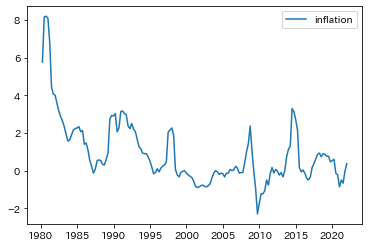

In [74]:
fig, ax = plt.subplots()
ax.plot('inflation', data=df)
ax.legend()
pass

````{admonition} 同様の図をSeriesのメソッド.plotを使って表示
:class: dropdown
```
df.loc[:,'inflation'].plot()
```
````

上下しているのが，過去約35年間は非常に安定している。図から持続性が強いことがわかるが，実際に計算してみよう。

In [75]:
df.loc[:,'inflation'].autocorr()

0.948654272538512

`0.949`は非常に高い持続性を意味しており，インフレが増加すると持続傾向にあることがわかる。次にトレンドからの乖離（％ポイント）を計算し，GDPのトレンドからの乖離と重ねて図示してみよう。

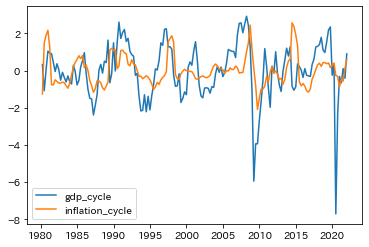

In [76]:
df['inflation_trend'] = py4macro.trend(df['inflation'])
df['inflation_cycle'] = df['inflation'] - df['inflation_trend']

cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots()
for i, v in enumerate(['gdp_cycle','inflation_cycle']):
    ax.plot(v, data=df, color=cmap(i))
    ax.legend()
pass

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
df[['gdp_cycle','inflation_cycle']].plot()
```
````

同じ方向に動く傾向が確認できる。相関係数を計算してみる。

In [77]:
df[['inflation_cycle','gdp_cycle']].corr()

,inflation_cycle,gdp_cycle
inflation_cycle,1.000000,0.308714
gdp_cycle,0.308714,1.000000


絶対値でみると失業程ではないが，正の相関性があることが確認できる。この結果から，インフレ率と失業率の負の相関が予測される。次に、自己相関係数を確認する。

In [78]:
df['inflation_cycle'].autocorr()

0.7771024330909324

トレンドからの乖離も強い持続性があることを示している。

### フラット化するフィリップス曲線

まずインフレ率と失業率の散布図をプロットしよう。

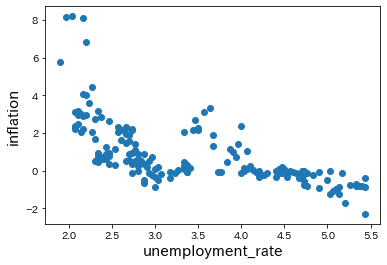

In [79]:
fig, ax = plt.subplots()
ax.scatter(x='unemployment_rate', y='inflation', data=df)
ax.set_xlabel('unemployment_rate', size=15)
ax.set_ylabel('inflation', size=15)
pass

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
df.plot(x='unemployment_rate', y='inflation', kind='scatter')
```
````

右下がりであり式[](eq:11-phillips)と整合的にみえる。上の散布図に１つの曲線を描いてそれをPC曲線と呼ぶこともできるだろう。一方で，次の問題を考えてみよう。
1. 過去40年間，フィリプス曲線は変化した可能性はないのか。即ち，真のメカニズムが変わりながら生成されたデータが表示されているのではないか，という問題である。
2. 式[](eq:11-phillips)には期待インフレ率がり，また供給サイドのショックもあり得る（例えば，コロナ禍）。それらをどう考えるかという問題がある。

第二の問題を扱うことはこのサイトの範囲を超えるので，ここでは扱わず議論を進めることにする。以下では第一の問題を考察してみよう。

景気循環のマクロ経済学での短期は何ヶ月または何年以下で，長期は何年以上なのだろうか。実は，曖昧で学者・学派によって見解が別れる事になる。ここでは10年間は長期に入ると考えることにする（多くの経済学者は同意するだろう）。この考えに基づくと，10年毎のデータを検討しPC曲線に変化があるかどうかを確かめることができる。

まず10年毎のデータを使い，`for`ループで式[](eq:11-phillips)の係数$a$と$b$を推定してみる。大きな差が無ければ，フィリップス曲線は概ね一定だと考えることができる。

In [82]:
start_list = ['1980 3', '1990 3', '2000 3', '2010 3']  # 1
end_list =   ['1989 12','1999 12','2009 12','2020 12'] # 2

a_list = []   # 3
b_list = []   # 4

for s, e in zip(start_list, end_list):                 # 5
    res = sm.ols('inflation ~ unemployment_rate',
                 data=df.loc[s:e,:]).fit()             # 6
    
    df[f'{s[:5]}年代データ'] = res.fittedvalues           # 7
    a_list.append(res.params[0])                       # 8
    b_list.append(res.params[1])                       # 9

```{admonition} コードの説明
:class: dropdown

1. 10年間の最初の四半期をリストとして`start_list`に割り当てる。要素を`1980-03-31`等としてもOK。
2. 10年間の最後の四半期をリストとして`end_list`に割り当てる。要素を`1989-12-31`等としてもOK。
3. 定数項の推定値を格納する空のリスト。
4. スロープ係数の推定値を格納する空のリスト。
5. `zip()`を使うことにより，一回のループで`start_list`と`end_list`の要素を`s`と`e`に割り当てることができる。
6. `data`にOLS推定する際に使用する`DataFrame`を指定するが，`.loc[s:e,:]`を使い10年間だけのデータを抽出している。
7. `res.fittedvalues`はOLSの予測値だが，新たな列として`df`に追加している。
    * 列ラベルとして`1980年代データ`のように設定しており，下でプロットする際の凡例に使うためである。
    * `s`は`start_list`の要素であり，文字列なので`[:5]`を使って最初の４文字を抽出している。
    * `f-string`を使うために`f`を置き`{}`の中に文字列を代入している。
8. `res.params`はOLS推定値の`Series`を返すので，その0番目の要素（定数項）を`a_list`に追加している。
9. `res.params`はOLS推定値の`Series`を返すので，その1番目の要素（スロープ係数）を`b_list`に追加している。
```

結果を`print`関数を使い表示する。

In [83]:
print('--- 定数項の推定値 -------------\n')

for s, a in zip(start_list, a_list):
    print(f'{s[:5]}年代：{a:>5.2f}')
    
    
print('\n--- スロープ係数の推定値 --------\n')

for s, b in zip(start_list, b_list):
    print(f'{s[:5]}年代：{b:.2f}')

--- 定数項の推定値 -------------

1980 年代：18.58
1990 年代： 4.37
2000 年代： 4.58
2010 年代： 1.79

--- スロープ係数の推定値 --------

1980 年代：-6.43
1990 年代：-1.04
2000 年代：-1.03
2010 年代：-0.41


定数項の推定値もスロープ係数の推定値も変化が大きく，特に1980年代の値とそれ以降の値の差が顕著である。傾きが緩やかになっているので，PC曲線のフラット化（需給ギャップに対してのインフレ率の弾性値の低下）と呼ばれている。研究では，日本だけではなく欧米でもPC曲線のフラット化が指摘されている。プロットして確認してみよう。

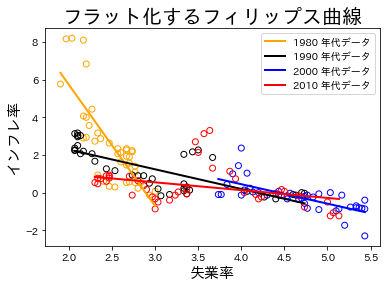

In [118]:
color_list = ['orange','black', 'blue', 'red'] # 1

fig, ax = plt.subplots()

for s, e, c in zip(start_list,
                   end_list,
                   color_list):
    
    ax.scatter('unemployment_rate',
               'inflation',
               data=df.loc[s:e,:],
               edgecolor=c,                    # 2
               facecolor='none',              # 3
               label='')

    ax.plot('unemployment_rate',
           f'{s[:5]}年代データ',
            data=df.loc[s:e,:].sort_values(f'{s[:5]}年代データ'),
            color=c,                           # 4
            linewidth=2                        # 5
            )

ax.set_title('フラット化するフィリップス曲線', size=20)
ax.set_xlabel('失業率', fontsize=15)
ax.set_ylabel('インフレ率', fontsize=15)
ax.legend()
pass

```{admonition} コードの説明
:class: dropdown

1. 色のリスト
    * `['orange','k', 'b', 'r']`としてもOK。
2. `edgecolor`は散布図の円形マーカーの縁の色を指定する引数。
3. `facecolor`は散布図の円形マーカーの内側の色を指定する引数。
4. `color`は直線の色を指定する引数。
5. `linewidth`は直線幅を指定する引数。
```

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
ax = df.plot('unemployment_rate', 'inflation', kind='scatter', c='none')

for s, e, c in zip(start_list, end_list, color_list):
    df.loc[s:e,:].plot('unemployment_rate', 'inflation', kind='scatter',
                       edgecolor=c,
                       c ='none',
                       s = 40,
                       ax=ax)
    df.loc[s:e,:].sort_values(f'{s[:5]}年代データ').plot('unemployment_rate',
                                                      f'{s[:5]}年代データ',
                                                      color=c, lw=2,
                                                      ax=ax)
ax.set_title('フラット化するフィリップス曲線', size=20)
ax.set_xlabel('失業率', fontsize=15)
ax.set_ylabel('インフレ率', fontsize=15)
ax.legend()
```
````

時間が経つにつれてPC曲線は右に横滑りしていることが確認できる。失業率に対してのインフレ率の反応が鈍くなっていることを示しているが，フラット化の原因は定かではなく，活発な研究がおこなわれている。原因として次の点が指摘されている。
1. 中央銀行の政策決定の透明化や政策のアナウンスメント，フォーワード・ガイダンス（将来の政策についてのガイダンス）などにより，中央銀行の物価安定（インフレ安定）重視のスタンスが民間に十分に浸透したと考えられる。失業が変化しても，インフレ率のの安定化を図る中央銀行の政策スタンスが民間の期待に織り込まれ，インフレ率の変化は小さくなったと思われる。この解釈が正しければ，日銀は素晴らしい仕事をしたということである。
2. グローバル化や規制改革により競争環境が変化し（例えば，需要曲線の変化や寡占化），その結果，企業の価格設定行動がも変化したためである。
3. 1980年代のPC曲線の傾きは，データ上では大きく見えるが，真のPC曲線はフラットだったという解釈である。上の散布図は観測されたデータを単純にプロットしただけであり，データだけを見てもその裏にあるデータ生成メカニズムは分からない。更には，1980年代にインフレ率が急に減少しているが，インフレ率の下落はPC曲線の下方シフトとして発生したと考えられ，それがデータ上ではPC曲線の急な傾きとして観測されているに過ぎない。
4. PC曲線は直線ではなく非線形であり，失業率が高くなると傾きが緩やかになる。直感的には次のように理解できる。企業にとって価格改定にはコストがかかる。従って，インフレ率が高い場合は企業は価格改定をしないと損をするのでより頻繁に価格を上昇させる。一方，インフレ率が低いと，価格改定しない場合の損失は大きくないので，価格の変化は頻繁に起こらなくなる。

解釈１〜３によると，「真のメカニズム」が変化したと考えることができる。一方，解釈４では「真のメカニズム」は変わらないという事になる。どの解釈がより妥当なのだろうか。非常に難しい問題であり，その解明が経済学の進歩につながる事は言うまでもない。（データと整合的な解釈が複数存在することは経済学でよくあることである。）

経済学に関するジョークに，真っ暗な部屋で黒猫を探す経済学者が登場するものがある。それを模して黒猫がPC曲線だとしよう。最初に黒猫の小さな可愛い鳴き声が聞こえ，５分後にまた同じ方向から鳴き声が聞こえたとする。それだけで，黒猫がいた場所が少しでも変わったかどうかを判断するとした場合，様々な解釈が成立する。「右に10cm動いているようだ。」「いや左に5cm。」「1m程右に動いて元の位置に戻っている。」「そもそも猫は2匹いて，最初の黒猫は他の場所に移り，もう一匹の三毛猫が鳴いたのではないか。」「2回目の鳴き声は幻聴だ。」非常に難しそうである。

```{admonition} 黒猫のジョーク
:class: note, dropdown

A mathematician, a theoretical economist and an econometrician are asked to find a black cat (who doesn't really exist) in a closed room with the lights off: 
* The mathematician (数学者) gets crazy trying to find a black cat that doesn't exist inside the darkened room and ends up in a psychiatric hospital. 
* The theoretical economist (理論経済学者) is unable to catch the black cat that doesn't exist inside the darkened room, but exits the room proudly proclaiming that he can construct a model to describe all his movements with extreme accuracy. 
* The econometrician (計量経済学者，特に経済データを用いて実証研究をする学者) walks securely into the darkened room, spend one hour looking for the black cat that doesn't exits and shouts from inside the room that he has it catched by the neck." 

[経済学のジョークのGoogle検索結果](https://www.google.co.jp/search?q=economics+jokes)
```

## インフレ率とマネーストックの増加率

### 説明

貨幣数量説は次式で表される。

$$
P_tY_t=M_tV_t
$$ (eq:11-qtm)

* $P_t$：一般物価水準
    * ある期間（1年間）で取引された財の集計物価水準
* $Y_t$：実質支出（GDP）
    * ある期間（1年間）で取引された財に対する実質支出額
* $M_t$：マネーストック
    * ある期間（1年間）平均で流通した貨幣量
* $V_t$：貨幣の流通速度
    * ある期間（1年間）平均で貨幣１単位が何回使用されたかを示す

式[](eq:11-qtm)に対数を取り時間微分すると次式となる。

$$
\pi_t+g_t=m_t+v_t
$$ (eq:11-qtm_growth)

ここで
* $\pi_t=\dfrac{\dot{P}_t}{P_t}$：インフレ率
* $g_t=\dfrac{\dot{Y_t}}{Y_t}$：実質GDPの成長率
* $m_t\equiv\dfrac{\dot{M}_t}{M_t}$：マネーストックの増加率
* $v_t=\dfrac{\dot{V}_t}{V_t}$：貨幣の流通速度の変化率

式[](eq:11-qtm)は恒等式であり，式[](eq:11-qtm_growth)も常に成り立つ関係である。ここで長期均衡を考えてみよう。GDPは供給サイドで決定され，成長率は一定（$g_t=\overline{g}$）としよう（ソロー・モデルを考えてみよう）。更に貨幣の流通速度は一定とする。この仮定のもと式[](eq:11-qtm_growth)は次式としてまとめることができる。

$$
\pi_t = m_t-\overline{g}
$$ (eq:11-qtm_growth_long)

この式によると，**長期的**なインフレ率はマネーストックの増加率によって決定される。この節では，式[](eq:11-qtm_growth_long)の予測がデータと整合的かどうかを議論する。次の２つのデータ・セットを使いこの問題を考察する。
* 日本の時系列データ
* 世界経済のパネル・データ

手法としては散布図と回帰直線の傾きに基づいて正の相関があるかを考える。

### 日本の時系列データ

#### 説明

`py4macro`には`jpn-money`というデータ・セットが含まれており，その内容は次のコードで確認できる。

In [27]:
py4macro.data('jpn-money', description=1)


    | `cpi`: 消費者物価指数
    |   * 2015年の値を`100`
    |   * 季節調整済み
    | `money`: マネーストック（M1）
    |   * 2015年の値を`100`
    |   * 季節調整済み
    |
    | * 月次データ
    | * 1955年1月〜2021年12月
    | * 行ラベル：毎月の最終日
    |
    | ＜出典＞
    | OECD Main Economic Indicators


1955年1月から2021年4月までの月次データであり，消費者物価指数とマネーストックの２つの変数が含まれている。マネーストックにはM1が使われており，現金通貨と要求払預金(預入期間の設定がなく自由に出し入れができる預金のことであり，普通預金が典型的な例)で構成される。詳しくは[マネーストック統計の解説](https://www.boj.or.jp/statistics/outline/exp/data/exms01.pdf)を参考にしてほしい。M1を使う大きな理由は長い時系列データが存在することであり，長期的な関係である式[](eq:11-qtm_growth_long)を考えるには適しているためである。

一方で長い時系列データであれば長期的な関係を捉えることができるという訳ではない。ここでの長期的な関係とは，ある作用が発生した後，その効果が現れるのに時間が掛かるという意味である。例えば，今日マネーストックの増加率が上昇したとしても，明日すぐにインフレ率の上昇につながるという訳ではなく，その効果が浸透しデータの数字に現れるまで数ヶ月掛かる事になる。この点を示すために次のステップで進めることにする。
1. 月次データを変換して次のデータを作成する。
    * 四半期データ
    * 年次データ
    * 1期を3年とするデータ（ここでは「3年次データ」と呼ぶ）
2. 月次データを含む４つのデータ・セットを使い，２変数の散布図と回帰分析をおこなう。

#### `resample()`

まず四半期データへの変換を考えよう。１四半期には３ヶ月の値があり，その平均を１四半期の値とする。同様に，年次データおよび3年次データに変換する場合は，12ヶ月間もしくは36ヶ月間の値を使い平均を計算することになる。このような計算は「連続的な時系列のグループ計算」として捉えることができる。グループ計算のメソッドに`groupby`があるが，カテゴリー変数に基づいてグループ分けするので，この問題に使うことはできない。その代わりに，時系列用グループ計算メソッドとして`resample`が用意されている。ここでは`resample`の使い方を紹介するが，異なる方法として移動平均を使うことも可能であり，興味がある人は[こちらを参照してみよう](https://py4basics.github.io/Moving_Average.html)。

```{note}
`resample`はグループ計算だけではなく，その「逆の計算」もすることができるがここでは触れない。以下では，「時系列グループ計算用」としてのみ考える。
```

`resample`の使い方を説明するために，次の`DataFrame`（変数名は`df_ex`）を考えよう。

In [28]:
date_index = pd.date_range('2020-01-31','2021-12-31', freq='M')
df_ex = pd.DataFrame({'X':list(range(10,120+1,10))*2,
                      'Y':np.random.normal(5,1,size=12*2)},index=date_index)

In [29]:
df_ex

,X,Y
2020-01-31,10,5.420161
2020-02-29,20,4.270878
2020-03-31,30,4.357305
2020-04-30,40,3.029146
2020-05-31,50,5.613106
2020-06-30,60,4.457799
2020-07-31,70,5.350555
2020-08-31,80,4.406609
2020-09-30,90,5.755454
2020-10-31,100,6.411022


`df_ex`には時系列用の行ラベルがが使われており，毎月の最後の日がラベルとなっている。列`X`には`10`から`120`までの整数が昇順に並んでおり，`Y`にはランダムは値が並んでいる。

２つのステップに分けて説明する。

**ステップ１**：グループ化の期間を指定する<br>
最初のステップでは，グループ化する期間を引数として`.resample()`を実行する。指定する期間は次のように文字列として指定する。
* `A`もしくは`Y`：１年を基準としてグループ化
* `Q`：四半期を基準としてグループ化
* `M`：１ヶ月を基準としてグループ化
    * 3ヶ月であれば`3M`，１年であれば`12M`とできるが，`Q`と`A`（`Y`）と挙動が少し異なるので注意が必要である。

`df_ex`を四半期でグループ化するには次のようになる。

In [30]:
df_ex.resample('Q')

このコードは`DataFrame`を返すわけではない。返すのは時系列グループ計算用のオブジェクトであり，それを使ってグループ計算をおこなう事になる。

**ステップ２**：計算内容を指定する。<br>
どのような計算をしたいかを指定する。ここではメソッド.mean()を使って指定した期間内の平均を計算してみよう。

In [31]:
df_ex.resample('Q').mean()

,X,Y
2020-03-31,20.0,4.682781
2020-06-30,50.0,4.366684
2020-09-30,80.0,5.170873
2020-12-31,110.0,6.409348
2021-03-31,20.0,4.774131
2021-06-30,50.0,4.543404
2021-09-30,80.0,5.299818
2021-12-31,110.0,4.235617


行ラベルには四半期の最後の日が使われている。列`X`に並んでいる数字から，毎四半期の期間内平均であることが確認できる。

次のコードは年平均を計算している。

In [32]:
df_ex.resample('A').mean()

,X,Y
2020-12-31,65.0,5.157421
2021-12-31,65.0,4.713243


平均以外にも様々な計算ができるようになっている。`see()`関数を使って属性を調べてみよう。

In [33]:
see(df_ex.resample('A'))

    .*                []                <                 <=                ==
    !=                >                 >=                dir()
    hash()            iter()            len()             repr()
    str()             .X                .Y                .agg()
    .aggregate()      .apply()          .asfreq()         .ax
    .backfill()       .bfill()          .binner           .count()
    .ffill()          .fillna()         .first()          .get_group()
    .groupby          .groups           .indices          .interpolate()
    .kind             .last()           .max()            .mean()
    .median()         .min()            .ndim             .nearest()
    .ngroups          .nunique()        .ohlc()           .pad()
    .pipe()           .plot()           .prod()           .quantile()
    .sem()            .size()           .std()            .sum()
    .transform()      .var()

主なメソッドとして次を挙げることができる（これらの計算で欠損値は無視される）。
* `mean()`：平均
* `median()`：中央値
* `max()`：最大値
* `min()`：最小値
* `std()`：標準偏差
* `var()`：分散
* `sum()`：合計
* `first()`：最初の値
* `last()`：最後の値
* `count()`：要素数

このリストにない計算をしたい場合は，上のリストにある.agg()（aggregate()も同じ）を使い`NumPy`や自作の関数を指定することができる。例えば，変動係数（coefficient of variation）を計算したいとしよう。

In [34]:
def cv(x):
    return x.std() / x.mean()

この関数の`x`は，時系列グループ計算で取り出された`Series`もしくは`DataFrame`と考えれば良いだろう。使い方は簡単で，`.agg()`の引数として`cv`を指定するだけである。

In [35]:
df_ex.resample('A').agg(cv)

,X,Y
2020-12-31,0.5547,0.210656
2021-12-31,0.5547,0.217815


```{warning}
`.agg()`の引数は`cv`であり`cv(x)`ではない。関数名だけを`.agg()`に渡し，`.agg()`が渡された関数を実行するというイメージである。`cv(x)`を引数に使うと，`cv(x)`を実行した**結果**を`.agg()`に渡すことになりエラーとなってしまう。
```

#### データの作成

では実際に`jpn-money`のデータを使いデータを整形しよう。まず月次データを読み込み`month`に割り当てる。

In [36]:
month = py4macro.data('jpn-money')
month.tail()

,cpi,money
,,
2021-08-31,101.618532,158.215194
2021-09-30,101.729035,158.977241
2021-10-31,101.401104,160.060574
2021-11-30,101.956670,161.054055
2021-12-31,102.045185,161.869633


いつもの通り`.info()`を使ってデータの内容を確認しよう。

In [37]:
month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 804 entries, 1955-01-31 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     804 non-null    float64
 1   money   804 non-null    float64
dtypes: float64(2)
memory usage: 18.8 KB


行ラベルが`DatetimeIndex`となっており，時系列データ用に設定されていることが分かる。

四半期データに変換して変数`quarter`に割り当てることにする。

In [38]:
quarter = month.resample('Q').mean()

これで３ヶ月の値の平均からなる四半期データを作成した事になる。確かめてみよう。

In [39]:
quarter.head()

,cpi,money
,,
1955-03-31,17.236707,0.347656
1955-06-30,16.874004,0.357257
1955-09-30,17.035517,0.384201
1955-12-31,16.875107,0.400080
1956-03-31,17.108284,0.394544


四半期の最後の日が行ラベルになっていることが分かる。同様に，年次データ作成しよう。

In [40]:
annual = month.resample('A').mean()
annual.head()

,cpi,money
,,
1955-12-31,17.005334,0.372299
1956-12-31,17.072603,0.424722
1957-12-31,17.601583,0.478435
1958-12-31,17.517496,0.505580
1959-12-31,17.707073,0.588486


１年の最後の日が行ラベルになっている。次に３年次データを作成しよう。

In [41]:
annual3 = month.resample('36M',closed='left',label='right').mean()     # 1
annual3.index = annual3.index - pd.tseries.frequencies.to_offset('M')  # 2
annual3.head()

,cpi,money
,,
1957-12-31,17.226506,0.425152
1960-12-31,17.854861,0.599932
1963-12-31,20.666763,1.039100
1966-12-31,24.291933,1.641735
1969-12-31,28.080477,2.570458


このコードは`quarter`と`annual`のコード少し異なる。コードの具体的な説明は割愛するが，何をしているかを簡単に説明する。１行目の引数`36M`は36ヶ月を意味している。`3A`とすることもできるが，変わった挙動をするので月数（つきすう）を使っている。また引数`closed='left'`と`label='right'`が追加されているが，`quarter`と`annual`と同様の計算・表示になるようにするためである。２行目は行ラベルが３年次の最後の日になるように設定している。

次にインフレ率とマネーストックの増加率の変化を計算し，新たな列としてそれぞれの`DataFrame`に追加しよう。増加率の公式に従ってコードを書いても良いが，`DataFrame`のメソッド`.pct_change()`を紹介する。これは名前が示すように（percent changeの略）列の変化率を計算するメソッドである。ここで注意が必要な点は，`.pct_change()`はデフォルトで前期比の増加率を返す。例えば，次のコードは`cpi`の前月と比べた増加率を計算している。
```
month.loc[:,'cpi'].pct_change()
```
同年同期比の増加率を計算したい場合は，12ヶ月前の値と比べたいので引数に`12`を指定すれば良い。例として，`quarter`で`cpi`の同年同期比のインフレ率を計算する場合は次のようになる。
```
month.loc[:,'cpi'].pct_change(4)
```
以下では，デフォルトで`.pct_change()`を使い計算する。

In [42]:
df_list = [month, quarter, annual, annual3]

for df in df_list:
    df['inflation'] = df.loc[:,'cpi'].pct_change()
    df['money_growth'] = df.loc[:,'money'].pct_change()

`month`を確認してみよう。

In [43]:
month.head()

,cpi,money,inflation,money_growth
,,,,
1955-01-31,17.219573,0.347029,NaN,NaN
1955-02-28,17.351247,0.350938,0.007647,0.011264
1955-03-31,17.139301,0.345003,-0.012215,-0.016910
1955-04-30,16.964259,0.353125,-0.010213,0.023541
1955-05-31,16.720857,0.354401,-0.014348,0.003613


行`1955-01-01`の`inflation`と`money_growth`の値は`NaN`となっている。これは前期の値がないためである。

#### 散布図とトレンド線

`for`ループを使ってOLSの計算とプロットを同時におこなおう。

```{admonition} コード説明
:class: dropdown

1. それぞれのプロットのタイトルのリスト。
2. 最小二乗法の結果を変数`res`に割り当てる。
3. `res.fittedvalues`はOLSの予測値であり，新たな列としてそれぞれの`DataFrame`に追加する。その際の列名を`トレンド`とする。
4. 散布図をプロット。
5. トレンド線をプロット。`.sort_values('トレンド')`を使って列`トレンド`を昇順になるように`df`を並び替える。
6. `color='r'`は色を赤に指定する。
7. `f-string`を使ってタイトルを`{t}`に代入している。
8. `f-string`を使ってスロープ係数の推定値を代入している。
    * `.pvalues`は推定値を抽出する`res`のメソッドであり，１番目の要素であるスロープ係数を`[1]`で指定している。
    * `:.3f`は小数点第三位まで表示することを指定している。
9. p値に関して(8)と同じことを行なっている。
10. 調整済み決定係数に対して(8)と同じことを行なっている。
11. `loc`はタイトルの位置を設定する引数。
    * `'left'`は左寄せ
    * `'right'`は右寄せ
    * `'center'`は中央（デフォルト）
```

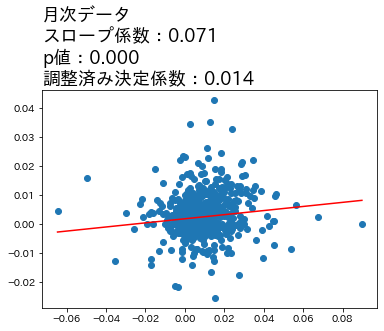

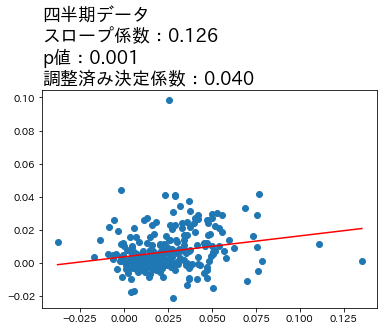

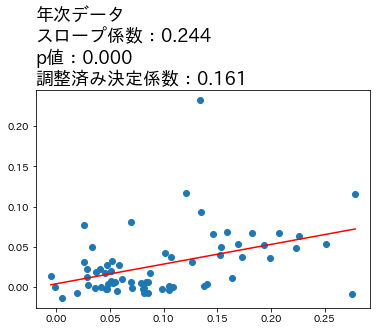

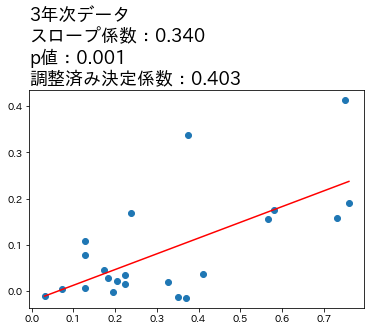

In [44]:
title_list = ['月次データ','四半期データ','年次データ','3年次データ']  # 1

for df, t in zip(df_list, title_list):
    
    res = sm.ols('inflation ~ money_growth', data=df).fit()  # 2
    df['トレンド'] = res.fittedvalues                          # 3
    
    fig, ax = plt.subplots()
    ax.scatter('money_growth', 'inflation', data=df)         # 4
    
    ax.plot('money_growth','トレンド', 
            data=df.sort_values('トレンド'),                   # 5
            color='r')                                       # 6
    ax.set_title(f'{t}\n'                                    # 7
                 f'スロープ係数：{res.params[1]:.3f}\n'         # 8
                 f'p値：{res.pvalues[1]:.3f}\n'               # 9
                 f'調整済み決定係数：{res.rsquared_adj:.3f}',    # 10
                 size=18, loc='left')                        # 11

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
for df, t in zip(df_list,title_list):
    
    res = sm.ols('inflation ~ money_growth', data=df).fit()
    df['トレンド'] = res.fittedvalues
    
    ax_ = df.plot('money_growth', 'inflation', kind='scatter')
    df.sort_values('トレンド').plot('money_growth','トレンド',
                                   color='r', ax=ax_)
    ax_.set_title(f'{t}\n'
                  f'スロープ係数：{res.params[1]:.3f}\n'
                  f'p値：{res.pvalues[1]:.3f}\n'
                  f'調整済み決定係数：{res.rsquared_adj:.3f}',
                  size=18, loc='left')
```
````

上の図とOLSの推定結果から次のことが分かる。
* 全てのケースで統計的優位性は高い。
* データの期間が長くなるとともに，スロープ係数の値が増加し，調整済み決定係数も高くなっている。

これらのことからマネーストックの変化の影響は，より長い期間をかけてインフレへの影響が発生していることが伺える。この結果は，式[](eq:11-qtm_growth_long)は長期的に成立することと整合的であると言えそうだ。

一方で，式[](eq:11-qtm_growth_long)は係数が`1`になることを予測しているが，上の4つのケースの係数は全て`1`よりも低い値となっている。この点を念頭に，次の節では日本だけではなく`170`国以上のデータを使い，問題を再検討することにする。また，OLS結果は因果関係を示しておらず単なる相関関係を表していることは念頭に置いておこう。

```{note}
４つの図の縦軸・横軸の値を比べると，データが長くなるにつれて値が大きくなることがわかる。期間が長くなると増加率も上昇するということである。注意してほしいのは，増加率が上昇したために正の相関が強くなったという訳ではなく，増加率がより高くなっても正の相関は弱いまま，もしくは相関が存在しない場合もあり得る。図が示しているのは，データの期間が長くなると正の相関が「炙り出される」ということである。
```

### 世界経済のパネルデータ

#### 説明

前節では日本のデータを使い，インフレ率に対するマネーストック増加率の影響が現れるには時間が掛かることを示した。一方でトレンド線の傾き（回帰分析のスロープ）は１よりも小さいが，式[](eq:11-qtm_growth_long)は線形であり，$m_t$の計数は１である。即ち，マネーストックの増加率が1％上昇するとインフレ率も1％増加するという予測である。データと理論予測の齟齬をどう考えれば良いだろうか。一つの問題はノイズである。年次データであっても3年次データであってもその期間に短期的なありとあらゆるランダムな要素（ノイズ）が含まれている。ノイズは正や負の両方の影響があると考えられ，その分変化が激しいと思われる。長期的な関係は，正と負の影響が相殺し，その結果残った関係と考えることができる。この考えをデータで捉えるためにデータ全体の平均を計算すれば良いことになる。しかし前節で使用した日本の1955年から2020年のデータを使い，インフレ率とマネーストトック増加率の平均を計算すると，標本の大きさは`１`となってしまう。これではどうしようもないので，国数を増やし，観測値を増やす必要がある。従って，ここでは世界経済のパネルデータを使い２変数の関係を探ることにする。

`py4macro`に含まれる`world-money`というデータ・セットを使うが，その内容は次のコードで確認できる。

In [45]:
py4macro.data('world-money',description=1)


    | `iso`: ISO国名コード
    | `country`: 国名
    | `year`: 年
    | `income_group`: 世界銀行が定義する所得グループ
    |   * High income
    |   * Upper Middle income
    |   * Lower Middle income
    |   * Low income
    | `money`: マネーストック（M1）
    | `deflator`: GDPディフレーター
    |
    | * 年次データ
    |
    | ＜注意点＞
    | * `money`と`deflator`が10年間以上連続で欠損値がない経済（177ヵ国）のみが含まれている。
    | * 国によって含まれるデータの`year`が異なる。
    | * 所得グループに関する情報
    |   https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups
    |
    | ＜出典＞
    | World Bank Development Indicators


国によってデータが使える期間が異なることに注意しよう。

まず変数`world`にデータを割り当てる。

In [46]:
world = py4macro.data('world-money')
world.head()

,iso,country,year,income_group,money,deflator
0,ALB,Albania,1994,Upper middle income,3.876590e+10,35.739368
1,ALB,Albania,1995,Upper middle income,5.925260e+10,39.302820
2,ALB,Albania,1996,Upper middle income,9.040510e+10,54.305537
3,ALB,Albania,1997,Upper middle income,9.166720e+10,60.409306
4,ALB,Albania,1998,Upper middle income,8.372854e+10,64.475001


いつも通り`.info()`を使って内容を確かめてみよう。

In [47]:
world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iso           6584 non-null   object 
 1   country       6584 non-null   object 
 2   year          6584 non-null   int64  
 3   income_group  6584 non-null   object 
 4   money         6584 non-null   float64
 5   deflator      6584 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 308.8+ KB


欠損値はないことが確認できる。

#### 変化率の計算

`world`には経済ごとに10年以上に渡ってインフレ率とマネーストック増加率が含まれている。国ごとの変数の変化率を計算するには，以前紹介した`.pivot()`を使うことも可能だが，少し回りくどい計算になっている。ここでは異なる方法として`.groupby()`を紹介する。`.groupby()`はグループ内で何らかの計算をする際に非常に便利なメソッドである。次のステップに従って説明する。
1. `DataFram`をどの変数でグループ化するかを指定し，グループ化計算用のオブジェクトを用意する。
    * ここでは経済ごとの平均を計算したいので，国`iso`（もしくは`country`）でグループ化する。
1. グループ計算したい列を選ぶ。
    * ここでは`money`と`deflation`となる。
1. どのような計算をしたいのかを指定する。
    * ここでは増加率なので`.pct_change()`を使う。

**＜ステップ１＞**<br>
グループ化用のオブジェクトの作成するためには`DataFrame`のメソッド`.groupby()`を使い，その引数にグループ化用の列を指定する。ここでは`world`を`iso`でグループ化した変数`world_group`に割り当てる。

In [48]:
world_group = world.groupby('iso')
world_group

`DataFrameGroupBy object`が生成されたことを知らせるメッセージである。このオブジェクトは`world`自体をグループ化計算用に変換したものであり，`DataFrame`のように`.loc[]`などのメソッドは用意されていないので注意しよう。

**＜ステップ２＞**<br>
グループ計算したいのは`money`と`deflator`である。同時に指定しても構わないが，ここでは一つずつ指定することにする。例として`money`を考えよう。列を指定するには`[]`を使う。

In [49]:
world_group['money']

`SeriesGroupBy object`が生成されたことを知らせるメッセージである。ステップ１で生成された`DataFrameGroupBy object`から`money`の箇所を取り出したグループ計算用オブジェクトである。`Series`となっていることから分かるように，`iso`でグループ化され列`money`専用のグループ計算オブジェクトである。

**＜ステップ３＞**<br>
グループ計算に平均を使いたいので，ステップ２のオブジェクトに`.pct_change()`をつか加えるだけである。

In [50]:
world_group['money'].pct_change()

0            NaN
1       0.528472
2       0.525758
3       0.013960
4      -0.086603
          ...   
6579    1.700756
6580   -0.538285
6581   -0.547881
6582    0.479342
6583    0.936070
Name: money, Length: 6584, dtype: float64

返されたのは国ごとに計算されたマネーストック増加率である。`Series`として返されているが，行の並びは`world`と同じである。従って，次のコードでマネーストック増加率の列を`world`に追加できる。

In [51]:
world['money_growth'] = world_group['money'].pct_change()*100
world.head()

,iso,country,year,income_group,money,deflator,money_growth
0,ALB,Albania,1994,Upper middle income,3.876590e+10,35.739368,NaN
1,ALB,Albania,1995,Upper middle income,5.925260e+10,39.302820,52.847219
2,ALB,Albania,1996,Upper middle income,9.040510e+10,54.305537,52.575752
3,ALB,Albania,1997,Upper middle income,9.166720e+10,60.409306,1.396050
4,ALB,Albania,1998,Upper middle income,8.372854e+10,64.475001,-8.660303


列`money_growth`が最後に追加さている。Albaniaの最初の行である0番目の行は`NaN`になっているが，増加率を計算する際に発生している。同様に，全ての国の最初の行には`NaN`が入っている（確かめてみよう）。

次にインフレ率を計算する。次のコードは上で説明した手順を１行で書いている。

In [52]:
world['inflation'] = world_group['deflator'].pct_change()*100

試しに，日本のデータだけを抽出してみよう。

In [53]:
world.query('iso=="JPN"')

,iso,country,year,income_group,money,deflator,money_growth,inflation
3022,JPN,Japan,1961,High income,4.102000e+12,24.337971,NaN,NaN
3023,JPN,Japan,1962,High income,6.090000e+12,25.360063,48.464164,4.199578
3024,JPN,Japan,1963,High income,7.702000e+12,26.757522,26.469622,5.510469
3025,JPN,Japan,1964,High income,8.704000e+12,28.183351,13.009608,5.328706
3026,JPN,Japan,1965,High income,1.028700e+13,29.631090,18.187040,5.136857
3027,JPN,Japan,1966,High income,1.171600e+13,31.104013,13.891319,4.970869
3028,JPN,Japan,1967,High income,1.336900e+13,32.813300,14.108911,5.495390
3029,JPN,Japan,1968,High income,1.515500e+13,34.427341,13.359264,4.918863
3030,JPN,Japan,1969,High income,1.828200e+13,35.953642,20.633454,4.433399
3031,JPN,Japan,1970,High income,2.421400e+13,44.213162,32.447216,22.972693


上で説明したように，列`money_growth`と`inflation`の0番目の行の要素は`NaN`となっている。

#### ハイパーインフレ

ハイパーインフレの確固たる定義はないが，Mankiwの教科書「マクロ経済学」では年率50％以上と定義している。この定義に基づき，ハイパーインフレは観測値の何％を占めるかを計算してみよう。まず`inflation`で`NaN`ではない行の数を数える。

In [54]:
notna = world.loc[:,'inflation'].notna().sum()
notna

6407

```{admonition} コードの説明
:class: dropdown

欠損値である`NaN`は`na`（not available）とも呼ばれる。メソッド`.notna()`は文字通り`na`ではない要素には`True`を`na`である要素には`False`を返す。`.sum()`は`True`の数を合計している。
```

`inflation`の値が`NaN`ではない行は6407あることがわかった。次に`inflation`が50％以上の行数を数えてみよう。

In [55]:
hyper = len( world.query('inflation >= 50') )
hyper

300

In [56]:
print(f'観測値の{100*hyper/notna:.2f}％でハイパーインフレが発生している。')

観測値の4.68％でハイパーインフレが発生している。


次に`inflation`の上位5ヵ国を表示してみよう。

In [57]:
world.sort_values('inflation',ascending=False).head()

,iso,country,year,income_group,money,deflator,money_growth,inflation
1413,COD,"Congo, Dem. Rep.",1994,Low income,3725130.0,0.001219,5635.381062,26765.858252
4277,NIC,Nicaragua,1988,Lower middle income,33480.0,0.000091,11673.429423,13611.634819
680,BOL,Bolivia,1985,Lower middle income,111800000.0,17.094034,3587.821612,12338.622324
4719,PER,Peru,1990,Upper middle income,707331500.0,3.608738,6724.820224,6261.239559
4279,NIC,Nicaragua,1990,Lower middle income,52778530.0,0.223530,6286.714344,5016.107950


トップはコンゴ共和国（COD）の年率26,766％！しかし，この数字はあまりピンとこないかもしれないので，次式を使って一日のインフレ率に換算してみよう。

$$
(1+g_{{日}})^{365}=1+g_{\text{年}}
\quad\Rightarrow\quad
g_{{日}}=(1+g_{\text{年}})^{\frac{1}{365}}-1
$$

ここで$g_{{年}}$は年率のインフレ率であり，$g_{{日}}$は1日当たりのインフレ率。この式を使い１に当たりの平均インフレ率を計算してみる。

In [58]:
inflation_cod = world.query('(iso=="COD") & (year==1994)').loc[:,'inflation']

inflation_cod_day = 100*( (1+inflation_cod/100)**(1/365)-1 )
inflation_cod_day

1413    1.544252
Name: inflation, dtype: float64

1日平均約1.54％のインフレ率となる。日本で考えると，最近の年率でのインフレ率よりも高い数字である（2021年8月現在）。もう少し身近に感じられるように，物価が２倍になるには何日かかるかを考えてみよう。$t$日後に物価は２倍になるとすると，次式が成立する。

$$
2=(1+g_{\text{日}})^t
\quad\Rightarrow\quad
t=\frac{\log(2)}{\log(1+g_{\text{日}})}
$$

この式を使って$t$を計算してみよう。

In [59]:
np.log(2)/np.log(1+inflation_cod_day/100)

1413    45.231317
Name: inflation, dtype: float64

約45日間で物価は２倍になることが分かる。

#### プロット

全てのデータを使って散布図をプロットしトレンドを計算してみる。

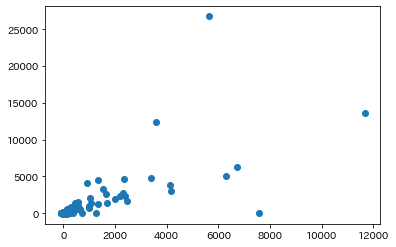

In [60]:
fig, ax = plt.subplots()
ax.scatter('money_growth', 'inflation', data=world)
pass

```{admonition} コードの説明
:class: dropdown

`world`には`inflation`と`money_growth`が`NaN`となっている行が含まれるが，上の図では自動的に省かれる。`world.dropna().plot()`としても図は変わらない。
```

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
world.plot('money_growth','inflation',kind='scatter')
```
````

横軸と縦軸の値（％）を確認してみると分かるが非常に大きい。ノイズの影響により変化が非常に激しいためである。トレンドのスロープを計算してみよう。

In [61]:
res_world = sm.ols('inflation ~ money_growth', data=world).fit()
print(f'標本の大きさ：{int(res_world.nobs)}')
print(f'調整済み決定係数：{res_world.rsquared_adj:.3f}')
res_world.summary().tables[1]

標本の大きさ：6407
調整済み決定係数：0.537


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.6447,3.843,-2.510,0.012,-17.178,-2.112
money_growth,1.2802,0.015,86.259,0.000,1.251,1.309


トレンドのスロープは1.28であり，1に近いがノイズの影響が大きいようである。

この結果と比較したいのが，次のケースである。
* それぞれの国で`inflation`と`money_growth`の平均を計算し，その散布図をプロットするとともに傾きを計算する。

まず，それぞれの経済の２変数の平均を計算するが，一つ注意点がある。`world`に`inflation`と`money_growth`があるので，`.mean()`を使って平均を計算すれば良いと思うかもしれない。しかし`.mean()`は算術平均であり，計算したいのは増加率の平均なので可能であれば幾何平均を使うべきである。残念ながら，`DataFrame`には幾何平均のメソッドが良いされて良いないので，次のように`for`ループで計算することにする。

In [62]:
money_growth_mean_list = []                   # 1
inflation_mean_list = []                      # 2
iso_list = []                                 # 3 
country_list = []                             # 4
income_group_list = []                        # 5

for c in world.loc[:,'iso'].unique():         # 6
    df = world.query('iso==@c').reset_index() # 7
    n = len(df)                               # 9
    
    money_growth_mean = 100*(                 # 9
        (df.loc[n-1,'money']/df.loc[0,'money'])**(1/(n-1))-1
    )
    inflation_mean = 100*(                    # 10
        (df.loc[n-1,'deflator']/df.loc[0,'deflator'])**(1/(n-1))-1
    )
                                              # 11
    money_growth_mean_list.append(money_growth_mean)
    inflation_mean_list.append(inflation_mean)
    iso_list.append(c)
                                              # 12
    country_list.append(df.loc[:,'country'].unique()[0])
    
                                              # 13
    income_group_list.append(df.loc[:,'income_group'].unique()[0])
    
                                              # 14
world_mean = pd.DataFrame({'country':country_list,
                           'income_group':income_group_list,
                           'money_growth_mean':money_growth_mean_list,
                           'inflation_mean':inflation_mean_list,
                           'iso':iso_list}).set_index('iso')

```{admonition} コードの説明
:class: dropdown

1. マネーストックの平均増加率を格納する空のリスト。
2. 平均インフレ率を格納する空のリスト。
3. 国のisoを格納する空のリスト。
4. 国名を格納するリスト。
5. 所得グループ名を格納するリスト。
6. データにある経済全てに対しての`for`ループを開始
    * `world.loc[:,'iso']`は列`iso`を抽出し，`.unique()`を使って経済のリストを作成する。
7. `.query('iso==@c')`で`c`国の行だけを抽出し，`reset_index()`で行インデックスを振り直す。`c`国の`DataFrame`を`df`に割り当てる。
8. `df`の行数を`n`に割り当てる。
9. `df`の列`money`の最初と最後の行の値を使って平均増加率を計算する。`100*`で％表示にする。
10. `df`の列`deflator`の最初と最後の行の値を使って平均インフレ率を計算する。`100*`で％表示にする。
11. `money_growth_mean`，`inflation_mean`，`c`をそれぞれ対応するリストに追加する。
12. 国名を`country_list`に追加する。
    * `df.loc[:,'country']`で列`country`を抽出し，`.unique()`で国名が入る`array`が返される。`[0]`はその0番目の要素を抽出している。
13. 所得グループ名を`income_group_list`に追加する。
    * `df.loc[:,'income_group']`で列`income_group`を抽出し，`.unique()`でグループ名が入る`array`が返される。`[0]`はその0番目の要素を抽出している。
14. `money_growth_mean_list`，`inflation_mean_list`，`country_list`を使い`DataFrame`を作成し`world_mean`に割り当てる。`.set_index('iso')`は`iso`を行ラベルに設定している。
```

````{tip}
実は`.groupby()`使って幾何平均を計算することも可能である。例えば，次のコードでマネーストック増加率の幾何平均を計算できる。
```
from scipy.stats import gmean            # 1

world.groupby('iso')['money'].agg(gmean) # 2
```
簡単なコードで良いが，(1)にある関数を導入する必要があり，また(2)の`.agg()`を使う必要がある。上のコードは`for`ループに慣れることを一つの目的としている。
````

平均でハイパーインフレが発生している国は何ヵ国なるのか計算してみよう。

In [63]:
hyper = ( world_mean.loc[:,'inflation_mean'] >= 50 ).sum()

print(f'{len(world_mean)}ヵ国中{hyper}ヵ国でハイパーインフレが発生している。')

177ヵ国中7ヵ国でハイパーインフレが発生している。


```{admonition} コードの説明
:class: dropdown

* `world_mean.loc[:,'inflation_mean']`で`inflation_mean`の列を抽出。
* `world_mean.loc[:,'inflation_mean'] >= 50`を使い，列`inflation_mean`の要素が50以上であれば`True`，50未満であれば`False`となる`Series`を返す。
* `True`は１，`False`は０と等しいので，`.sum()`で合計することによってハイパーインフレ国の数が計算できる。
```

短期的なノイズの影響によってある年にハイパーインフレが発生する場合もあるだろう。しかしこの結果は，長期的にハイパーインフレに悩まされる国が存在することを示している。どのような国なのかを確認するために，インフレ率上位10ヵ国を表示してみよう。

In [64]:
world_mean.sort_values(by='inflation_mean', ascending=False).head(10)

,country,income_group,money_growth_mean,inflation_mean
iso,,,,
COD,"Congo, Dem. Rep.",Low income,122.442962,127.704505
AGO,Angola,Lower middle income,108.457354,92.231798
BRA,Brazil,Upper middle income,92.023344,88.882771
ARG,Argentina,Upper middle income,79.169900,74.971614
NIC,Nicaragua,Lower middle income,67.774841,62.717663
BLR,Belarus,Upper middle income,65.667637,62.536094
UKR,Ukraine,Lower middle income,58.537270,61.867179
PER,Peru,Upper middle income,54.905117,48.305760
ARM,Armenia,Upper middle income,48.970412,46.680070


やはり所得水準が比較的に低い国が入っている。

`world_mean`を使いクロスセクションのデータをプロットしてみよう。

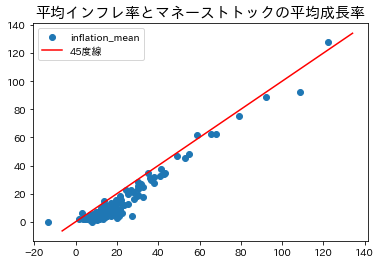

In [65]:
fig, ax = plt.subplots()
ax.scatter('money_growth_mean','inflation_mean', data=world_mean)
xpoints = ypoints = ax.get_ylim()
ax.plot(xpoints,ypoints,'r-', label='45度線')
ax.set_title('平均インフレ率とマネーストトックの平均成長率', size='15')
ax.legend()
pass

````{admonition} 同様の図をDataFrameのメソッド.plotを使って表示
:class: dropdown
```
ax_ = world_mean.plot('money_growth_mean','inflation_mean', kind='scatter')
xpoints = ypoints = ax_.get_ylim()
ax_.plot(xpoints,ypoints,'r-', label='45度線')
ax_.set_title('平均インフレ率とマネーストトックの平均成長率', size='15')
ax_.legend()
```
````

綺麗に45度線上に並んでいる。国ごとに平均を計算することによって短期的なノイズが相殺され長期的な関係が浮かび上がっている。トレンド線の傾きを計算してみよう。

In [66]:
res_world_mean = sm.ols('inflation_mean ~ money_growth_mean', data=world_mean).fit()
print(f'標本の大きさ：{int(res_world_mean.nobs)}')
print(f'調整済み決定係数：{res_world_mean.rsquared_adj:.3f}')
print(res_world_mean.summary().tables[1])

標本の大きさ：177
調整済み決定係数：0.945
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.0805      0.461    -13.175      0.000      -6.991      -5.170
money_growth_mean     0.9847      0.018     54.876      0.000       0.949       1.020


推定値は１に非常に近い。もし図の左下にある外れ値のように見える値（ジンバブエ）を省くとスロープ係数は0.997になる。長期的には式[](eq:11-qtm_growth_long)が示すように，マネーストック増加率の1％上昇はインフレ率1％上昇につかがること示す結果である。「真のメカニズム」の一部が垣間見えるような気がしませんか。